Your final report should be written up in a Jupyter notebook.  It should be posted to a public Github repo as an ipynb AND it should be saved as an html file and submitted to this assignment via courseworks.  Please include the link to your Github repo in this html file.

Feel free to use R, Excel, or your preferred program to update your csv file before building your model.    You are welcome, but not required, to add any other country level features you would like to your dataset before using the data to complete your report. 

### Your report should include the following information:

### Explore bivariate results (Use visualizations!)
- Describe any relationships you see between particular features and the target variable

### Examine features that predict happiness categories using one or more models that allow for automatic feature selection
- Explain any meaningful findings

### Run at least three prediction models to try to predict World Happiness well.

- Discuss which models performed better and point out relevant hyper-parameter values for successful models.
  - Gradiant Boosting(XGBoost)
  - Keras
  - SVM
  
  
- Submit your best model to the leader board for the World Happiness AI Model Share competition.
   - You have the option to present and/or discuss these models in your report, but it is not required.

## EDA Plan
     1. Understanding Data: Check columns, data type, null values, shape, etc..
     2. Build graphs to explkore bivariate relationships between feautres and the target vairables to draw insights for modeling.
     3. Get ride of Outliers
     ## 4. If we were to recode "region" into dummies, would that improve the model?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
Happy = pd.read_csv("worldhappiness2019.csv")
Happy.shape

(156, 11)

In [3]:
level_counts = Happy.groupby("Happiness_level").Happiness_level.count()
level_counts

Happiness_level
Average      31
High         32
Low          31
Very High    31
Very Low     31
Name: Happiness_level, dtype: int64

In [4]:
Happy.head()

,Happiness_level,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region
0,Very High,Finland,1.340,1.587,0.986,0.596,0.153,0.393,Finland,Europe,Northern Europe
1,Very High,Denmark,1.383,1.573,0.996,0.592,0.252,0.410,Denmark,Europe,Northern Europe
2,Very High,Norway,1.488,1.582,1.028,0.603,0.271,0.341,Norway,Europe,Northern Europe
3,Very High,Iceland,1.380,1.624,1.026,0.591,0.354,0.118,Iceland,Europe,Northern Europe
4,Very High,Netherlands,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands,Europe,Western Europe


In [5]:
Happy.describe()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,0.905147,1.208814,0.725244,0.392571,0.184846,0.110603
std,0.398389,0.299191,0.242124,0.143289,0.095254,0.094538
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.602750,1.055750,0.547750,0.308000,0.108750,0.047000
50%,0.960000,1.271500,0.789000,0.417000,0.177500,0.085500
75%,1.232500,1.452500,0.881750,0.507250,0.248250,0.141250
max,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000


## Plots exploring bivariate relationships between each feature and the target variable

In [6]:
def categorical_plot(df,feature,label):
    sns.boxplot(data=df,x='Happiness_level',y=feature).set_title(label)

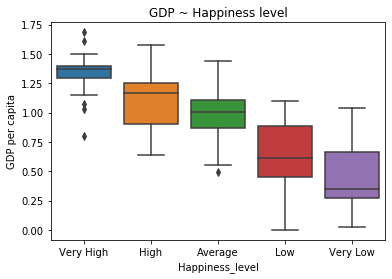

In [7]:
categorical_plot(Happy,'GDP per capita', "GDP ~ Happiness level")

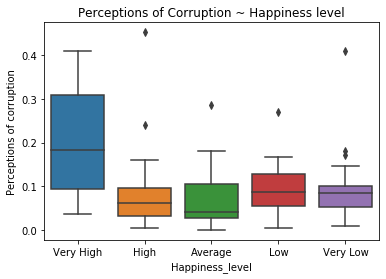

In [8]:
categorical_plot(Happy,'Perceptions of corruption', "Perceptions of Corruption ~ Happiness level")

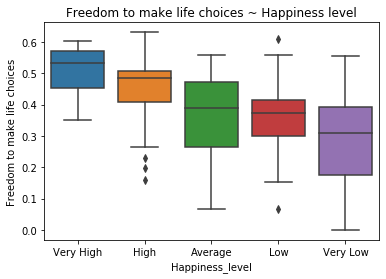

In [9]:
categorical_plot(Happy,'Freedom to make life choices', "Freedom to make life choices ~ Happiness level")

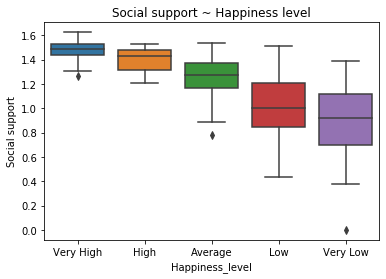

In [10]:
categorical_plot(Happy,'Social support', "Social support ~ Happiness level")

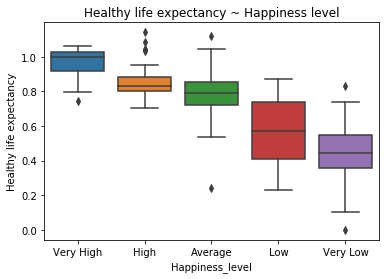

In [11]:
categorical_plot(Happy,'Healthy life expectancy', "Healthy life expectancy ~ Happiness level")

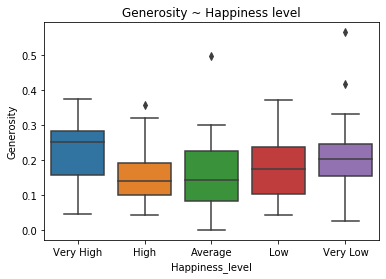

In [12]:
categorical_plot(Happy,'Generosity', "Generosity ~ Happiness level")

**Conclusion:** The graphs above show that features such us GDP per capita, Freedom to make life choices, Social support, Healthy life expectancy all have a positive correlation with people's happiness level.

## Remove Outliers using Interquartile Range (IQR)

In [13]:
Q1 = Happy.quantile(0.25)
Q3 = Happy.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

GDP per capita                  0.62975
Social support                  0.39675
Healthy life expectancy         0.33400
Freedom to make life choices    0.19925
Generosity                      0.13950
Perceptions of corruption       0.09425
dtype: float64


In [14]:
Happy_out = Happy[~((Happy < (Q1 - 1.5 * IQR)) |(Happy > (Q3 + 1.5 * IQR))).any(axis=1)]
print(Happy_out.shape)

(134, 11)


## Preprocess Data and 

In [15]:
# Clean up final region data
X = Happy.drop(['Happiness_level', 'name', 'Country or region', 'sub-region'], axis=1)
y = Happy['Happiness_level']

X.shape, y.shape

((156, 7), (156,))

   **- Preprocess data using Column Transformer and save fit preprocessor to ".pkl" file**

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features=X.columns.tolist()
numeric_features.remove('region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


#Fit your preprocessor object
preprocess=preprocessor.fit(X) 

In [17]:
# Write function to transform data with preprocessor

def preprocessor(data):
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [18]:
# Check shape for keras input:
preprocessor(X).shape # pretty small dataset

(156, 11)

In [19]:
# Check shape for keras output:
pd.get_dummies(y).shape

(156, 5)

In [20]:
X["region"].value_counts()

Asia        46
Africa      45
Europe      40
Americas    23
Oceania      2
Name: region, dtype: int64

**- One-Hot Encoding target variable**

In [21]:
y1 = pd.get_dummies(y)
y1.head()

,Average,High,Low,Very High,Very Low
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


**- Using get dummies approach to encode region column**

In [22]:
X1 = pd.get_dummies(X, columns=["region"])

In [23]:
X1.head()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,region_Africa,region_Americas,region_Asia,region_Europe,region_Oceania
0,1.340,1.587,0.986,0.596,0.153,0.393,0,0,0,1,0
1,1.383,1.573,0.996,0.592,0.252,0.410,0,0,0,1,0
2,1.488,1.582,1.028,0.603,0.271,0.341,0,0,0,1,0
3,1.380,1.624,1.026,0.591,0.354,0.118,0,0,0,1,0
4,1.396,1.522,0.999,0.557,0.322,0.298,0,0,0,1,0


## Automatic Feature Selection using Random Forest Classifier

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier(n_estimators=100, random_state=42)
select = SelectFromModel(
RandomForest,
threshold="median")


In [25]:
#select.fit(X1, y1)
#X1_l1 = select.transform(X1)
X1_l1 = select.fit_transform(X1, y1)
print("X1.shape: {}".format(X1.shape))
print("X1_l1.shape: {}".format(X1_l1.shape))

X1.shape: (156, 11)
X1_l1.shape: (156, 6)


In [26]:
type(X1_l1)

numpy.ndarray

In [27]:
print("We started with {0} features but retained only {1} of them!".format(X1.shape[1] - 1, X1_l1.shape[1]))  

We started with 10 features but retained only 6 of them!


In [28]:
#How do I plot feature importances by ascending order?

In [30]:
#print("Feature importances:\n{}".format(RandomForest.feature_importances_))

## Building Prediction Models

In [31]:
# Set up training and test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1_l1, y1, test_size=.33, random_state=42)

print(X_train.shape)
print(y_train.shape)

(104, 6)
(104, 5)


### 1. KNN Classification

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
param_gridknn = {'n_neighbors': range(1, 10)}
knn = KNeighborsClassifier().fit(X_train,y_train)
knn_grid = GridSearchCV(knn, param_gridknn).fit(X_train,y_train)

print("Test set Score: {:.2f}".format(knn_grid.score(X_test, y_test)))
print("Best Parameter: {}".format(knn_grid.best_params_))

Test set Score: 0.38
Best Parameter: {'n_neighbors': 3}


### 2. Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
gradientB = GradientBoostingClassifier()
#gradientB.fit(X_train, y_train)

#print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

### 2. Random Forrest

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.269


## 3. Support Vector Machine

In [35]:
from sklearn.svm import SVC
svc = SVC()
#svc.fit(X_train, y_train)
#print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
#print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

### 4. Nerual Network with Keras

In [36]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [58]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD


# create model
NN = Sequential()
NN.add(Dense(64, input_dim=6, activation='relu'))
NN.add(Dense(200, activation='relu'))
NN.add(Dense(200, activation='relu'))
NN.add(Dense(100, activation='relu'))
NN.add(Dense(5, activation='softmax'))
# Compile model
NN.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

                                                                  
# Fitting the NN to the Training set
NN.fit(X_train, y_train, 
               batch_size = 60, 
               epochs = 300, validation_split=0.35)  


Epoch 1/300
2/2 [==============================] - 0s 64ms/step - loss: 1.6199 - accuracy: 0.1791 - val_loss: 1.6151 - val_accuracy: 0.2162
Epoch 2/300
2/2 [==============================] - 0s 8ms/step - loss: 1.6161 - accuracy: 0.1791 - val_loss: 1.6134 - val_accuracy: 0.2162
Epoch 3/300
2/2 [==============================] - 0s 8ms/step - loss: 1.6127 - accuracy: 0.1791 - val_loss: 1.6127 - val_accuracy: 0.2703
Epoch 4/300
2/2 [==============================] - 0s 8ms/step - loss: 1.6088 - accuracy: 0.1940 - val_loss: 1.6114 - val_accuracy: 0.2973
Epoch 5/300
2/2 [==============================] - 0s 8ms/step - loss: 1.6056 - accuracy: 0.3582 - val_loss: 1.6103 - val_accuracy: 0.2973
Epoch 6/300
2/2 [==============================] - 0s 8ms/step - loss: 1.6031 - accuracy: 0.3731 - val_loss: 1.6093 - val_accuracy: 0.3514
Epoch 7/300
2/2 [==============================] - 0s 9ms/step - loss: 1.6004 - accuracy: 0.3731 - val_loss: 1.6083 - val_accuracy: 0.3514
Epoch 8/300
2/2 [=========

2/2 [==============================] - 0s 8ms/step - loss: 1.5211 - accuracy: 0.4478 - val_loss: 1.5870 - val_accuracy: 0.2432
Epoch 60/300
2/2 [==============================] - 0s 8ms/step - loss: 1.5199 - accuracy: 0.3582 - val_loss: 1.5867 - val_accuracy: 0.2703
Epoch 61/300
2/2 [==============================] - 0s 7ms/step - loss: 1.5191 - accuracy: 0.3881 - val_loss: 1.5883 - val_accuracy: 0.2432
Epoch 62/300
2/2 [==============================] - 0s 8ms/step - loss: 1.5173 - accuracy: 0.4179 - val_loss: 1.5892 - val_accuracy: 0.1892
Epoch 63/300
2/2 [==============================] - 0s 8ms/step - loss: 1.5160 - accuracy: 0.3433 - val_loss: 1.5871 - val_accuracy: 0.2432
Epoch 64/300
2/2 [==============================] - 0s 8ms/step - loss: 1.5146 - accuracy: 0.4030 - val_loss: 1.5864 - val_accuracy: 0.2432
Epoch 65/300
2/2 [==============================] - 0s 8ms/step - loss: 1.5135 - accuracy: 0.4030 - val_loss: 1.5874 - val_accuracy: 0.1892
Epoch 66/300
2/2 [===============

2/2 [==============================] - 0s 9ms/step - loss: 1.4388 - accuracy: 0.4627 - val_loss: 1.5583 - val_accuracy: 0.2973
Epoch 118/300
2/2 [==============================] - 0s 8ms/step - loss: 1.4374 - accuracy: 0.3881 - val_loss: 1.5614 - val_accuracy: 0.2432
Epoch 119/300
2/2 [==============================] - 0s 8ms/step - loss: 1.4363 - accuracy: 0.3881 - val_loss: 1.5537 - val_accuracy: 0.2973
Epoch 120/300
2/2 [==============================] - 0s 8ms/step - loss: 1.4353 - accuracy: 0.3881 - val_loss: 1.5525 - val_accuracy: 0.2973
Epoch 121/300
2/2 [==============================] - 0s 8ms/step - loss: 1.4336 - accuracy: 0.3881 - val_loss: 1.5500 - val_accuracy: 0.3243
Epoch 122/300
2/2 [==============================] - 0s 7ms/step - loss: 1.4331 - accuracy: 0.4030 - val_loss: 1.5516 - val_accuracy: 0.2973
Epoch 123/300
2/2 [==============================] - 0s 8ms/step - loss: 1.4309 - accuracy: 0.3881 - val_loss: 1.5478 - val_accuracy: 0.2973
Epoch 124/300
2/2 [========

2/2 [==============================] - 0s 9ms/step - loss: 1.3360 - accuracy: 0.4478 - val_loss: 1.5135 - val_accuracy: 0.2973
Epoch 176/300
2/2 [==============================] - 0s 8ms/step - loss: 1.3328 - accuracy: 0.4478 - val_loss: 1.5068 - val_accuracy: 0.2973
Epoch 177/300
2/2 [==============================] - 0s 9ms/step - loss: 1.3313 - accuracy: 0.4627 - val_loss: 1.5121 - val_accuracy: 0.2973
Epoch 178/300
2/2 [==============================] - 0s 9ms/step - loss: 1.3301 - accuracy: 0.4478 - val_loss: 1.5025 - val_accuracy: 0.2973
Epoch 179/300
2/2 [==============================] - 0s 8ms/step - loss: 1.3274 - accuracy: 0.4925 - val_loss: 1.5016 - val_accuracy: 0.2973
Epoch 180/300
2/2 [==============================] - 0s 9ms/step - loss: 1.3249 - accuracy: 0.4925 - val_loss: 1.5045 - val_accuracy: 0.2973
Epoch 181/300
2/2 [==============================] - 0s 8ms/step - loss: 1.3223 - accuracy: 0.4627 - val_loss: 1.4961 - val_accuracy: 0.2973
Epoch 182/300
2/2 [========

Epoch 233/300
2/2 [==============================] - 0s 8ms/step - loss: 1.2129 - accuracy: 0.5672 - val_loss: 1.4083 - val_accuracy: 0.4054
Epoch 234/300
2/2 [==============================] - 0s 8ms/step - loss: 1.2111 - accuracy: 0.5821 - val_loss: 1.4088 - val_accuracy: 0.4054
Epoch 235/300
2/2 [==============================] - 0s 8ms/step - loss: 1.2083 - accuracy: 0.5373 - val_loss: 1.4160 - val_accuracy: 0.3784
Epoch 236/300
2/2 [==============================] - 0s 9ms/step - loss: 1.2061 - accuracy: 0.5075 - val_loss: 1.4411 - val_accuracy: 0.3243
Epoch 237/300
2/2 [==============================] - 0s 9ms/step - loss: 1.2068 - accuracy: 0.4627 - val_loss: 1.4402 - val_accuracy: 0.3243
Epoch 238/300
2/2 [==============================] - 0s 8ms/step - loss: 1.2055 - accuracy: 0.4627 - val_loss: 1.4490 - val_accuracy: 0.3243
Epoch 239/300
2/2 [==============================] - 0s 8ms/step - loss: 1.2037 - accuracy: 0.4627 - val_loss: 1.4287 - val_accuracy: 0.3514
Epoch 240/300

2/2 [==============================] - 0s 8ms/step - loss: 1.1066 - accuracy: 0.5672 - val_loss: 1.3974 - val_accuracy: 0.2973
Epoch 292/300
2/2 [==============================] - 0s 8ms/step - loss: 1.1048 - accuracy: 0.5224 - val_loss: 1.3762 - val_accuracy: 0.3243
Epoch 293/300
2/2 [==============================] - 0s 8ms/step - loss: 1.1032 - accuracy: 0.5075 - val_loss: 1.3357 - val_accuracy: 0.3784
Epoch 294/300
2/2 [==============================] - 0s 8ms/step - loss: 1.1037 - accuracy: 0.5821 - val_loss: 1.3556 - val_accuracy: 0.3514
Epoch 295/300
2/2 [==============================] - 0s 8ms/step - loss: 1.0993 - accuracy: 0.5522 - val_loss: 1.3462 - val_accuracy: 0.3784
Epoch 296/300
2/2 [==============================] - 0s 8ms/step - loss: 1.0975 - accuracy: 0.6119 - val_loss: 1.3510 - val_accuracy: 0.3514
Epoch 297/300
2/2 [==============================] - 0s 8ms/step - loss: 1.0951 - accuracy: 0.5373 - val_loss: 1.3848 - val_accuracy: 0.2973
Epoch 298/300
2/2 [========

In [59]:
# using predict_classes() for multi-class data to return predicted class index.

print(NN.predict_classes(X_test))
prediction_index=NN.predict_classes(X_test)

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=y_train.columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 1 0 1 4 3 0 0 0 0 3 1 3 1 3 1 4 4 4 1 4 3 3 3 1 0 0 0 1 4 0 1 1 4 1 4 4
 0 1 0 0 1 4 3 3 1 4 1 1 0 1 0]
['High', 'High', 'Average', 'High', 'Very Low', 'Very High', 'Average', 'Average', 'Average', 'Average', 'Very High', 'High', 'Very High', 'High', 'Very High', 'High', 'Very Low', 'Very Low', 'Very Low', 'High', 'Very Low', 'Very High', 'Very High', 'Very High', 'High', 'Average', 'Average', 'Average', 'High', 'Very Low', 'Average', 'High', 'High', 'Very Low', 'High', 'Very Low', 'Very Low', 'Average', 'High', 'Average', 'Average', 'High', 'Very Low', 'Very High', 'Very High', 'High', 'Very Low', 'High', 'High', 'Average', 'High', 'Average']


In [60]:
Y_test = y_test.to_numpy()

In [61]:
y_labels=np.argmax(Y_test, axis=1)
y_labels.shape

(52,)

In [62]:
prediction_index.shape

(52,)

In [63]:
# Evaluate held out test data
from sklearn.metrics import accuracy_score

print("Accuracy: {:.2f}%".format(accuracy_score(y_labels,prediction_index) * 100))

Accuracy: 40.38%


## Save Preprocessor fxn to "preprocessor.zip"

In [64]:
#install aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
Requirement already up-to-date: aimodelshare in /Users/xuejingli/opt/anaconda3/lib/python3.7/site-packages (0.0.22)


In [65]:
pip install --upgrade dill

Requirement already up-to-date: dill in /Users/xuejingli/opt/anaconda3/lib/python3.7/site-packages (0.3.3)
Note: you may need to restart the kernel to use updated packages.


In [66]:
pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /Users/xuejingli/opt/anaconda3/lib/python3.7/site-packages (0.24.1)
Note: you may need to restart the kernel to use updated packages.


In [67]:
#Save preprocessor function to local "preprocessor.zip" file for leaderboard submission
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

ModuleNotFoundError: No module named 'pydot'

In [ ]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(NN, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

## Model Submission

In [68]:

#aimodelshare username and password
username = "xuejingli"
password = "ABc@@1997"

# load submit model creds (only gives access to s3 bucket)
# Load from pkl file
import pickle
with open("aws_creds_worldhappiness.pkl", 'rb') as file:
    aws_key,aws_password,region = pickle.load(file)

token=ai.aws.get_aws_token(username, password)
awscreds=ai.aws.get_aws_client(aws_key=aws_key, aws_secret=aws_password, aws_region=region)

NameError: name 'ai' is not defined

In [ ]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

### Link to Github Repo: https://github.com/GraceXuejingLi/MLProject2021
